import packages

In [511]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

build synthetic dataset

In [512]:
seed = 42
np.random.seed(seed)

#original loan amount
#credit score
#ltv
#vehicle_type
#number of late payments
#loan_default

In [513]:
min_loan = 4000
max_loan = 75000
n_loans = 1000

orig_loan_bal = []

for i in np.arange(0, n_loans, 1):
    orig_bal = np.random.randint(min_loan, max_loan)
    orig_bal = round(orig_bal, -2)
    orig_loan_bal.append(orig_bal)

In [514]:
min_ltv = 50
max_ltv = 120

orig_ltv = []

for i in orig_loan_bal:
    ltv = min_ltv + (i - min_loan) / (max_loan - min_loan) * (max_ltv - min_ltv)

    noise = np.random.normal(-40, 40)

    ltv = ltv + noise

    ltv = max(min_ltv, min(max_ltv, ltv))

    orig_ltv.append(round(ltv, 2))


In [515]:
min_score = 550
max_score = 850

orig_credit_score = []

for i, j in zip(orig_loan_bal, orig_ltv):
    if j > 100:
        score = min_score + (i - min_loan) / (max_loan - min_loan) * (max_score - min_score)
        noise = np.random.normal(-125, 55)
        score = score + noise
        orig_credit_score.append(round(max(min_score, min(max_score, score))))

    else:
        score = min_score + (i - min_loan) / (max_loan - min_loan) * (max_score - min_score)
        noise = np.random.normal(-70, 70)
        score = score + noise
        orig_credit_score.append(round(max(min_score, min(max_score, score))))

In [516]:
max_late_payments = 12

orig_late_payments = []

for i, j in zip(orig_credit_score, orig_ltv):
    # Create a "risk score" combining credit and LTV
    credit_risk = (max_score - i) / (max_score - min_score)  # 0-1, higher = riskier
    ltv_risk = (j - 50) / (120 - 50)  # 0-1, higher LTV = riskier
    
    # Combined risk (weight credit more heavily)
    combined_risk = (credit_risk * 0.8) + (ltv_risk * 0.2)  
    
    # Scale to late payment probability
    expected_late = combined_risk * 2
    
    # Add some randomness but keep it realistic
    late_payments = np.random.poisson(expected_late)  # Poisson for count data
    late_payments = min(max_late_payments, late_payments)  # Cap at 12
    
    orig_late_payments.append(late_payments)

In [517]:
vehicle_types = ['NEW', 'USED']
weight = [0.3, 0.7]

orig_vehicle_type = random.choices(vehicle_types, weights=weight, k=n_loans)

In [518]:
default = []

for loan, credit_score, ltv, late_payments, vehicle in zip(orig_loan_bal, orig_credit_score, orig_ltv, orig_late_payments, orig_vehicle_type):
    # Base default probability
    default_prob = 0.55  # Base 10% default rate

    # Increase probability for high LTV
    loan_factor = -0.05 * (loan - min_loan) / (max_loan - min_loan)
    credit_score_factor = -0.065 * (max_score - credit_score) / (max_score - min_score)

    ltv_factor = 0.05 * max(0, (ltv - 80) / 100)
    late_payments_factor = 0.03 * late_payments 
    vehicle_factor = -0.03 if vehicle == "NEW" else 0.01

    prob_default = default_prob + ltv_factor + loan_factor + credit_score_factor + late_payments_factor + vehicle_factor

    prob_default = min(0.95, max(0, prob_default))

    prob_default += np.random.normal(-0.01, 0.04)


    default.append(prob_default)

In [519]:
binary_default = lambda x: 1 if x > 0.6 else 0

loan_data = pd.DataFrame({
    'original_loan_amount': orig_loan_bal,
    'credit_score': orig_credit_score,
    'ltv': orig_ltv,
    'vehicle_type': orig_vehicle_type,
    'late_payments': orig_late_payments,
    'loan_default': list(map(binary_default, default))
})

In [520]:
# Check vehicle type vs default rates
print(loan_data.groupby('vehicle_type')['loan_default'].agg(['count', 'mean']))

              count      mean
vehicle_type                 
NEW             297  0.020202
USED            703  0.059744


In [521]:
# See if credit score and vehicle type are correlated
print("Average credit score by vehicle type:")
print(loan_data.groupby('vehicle_type')['credit_score'].mean())

# Check credit score distribution in defaults vs non-defaults
print("Credit score by default status:")
print(loan_data.groupby('loan_default')['credit_score'].agg(['mean', 'std']))

Average credit score by vehicle type:
vehicle_type
NEW     647.703704
USED    640.196302
Name: credit_score, dtype: float64
Credit score by default status:
                    mean        std
loan_default                       
0             643.850840  86.617442
1             614.166667  69.845828


Manual Tree Building

In [522]:
# Test potential splits to see which best separates defaults
print("Overall default rate:", loan_data['loan_default'].mean())
print("\n--- Testing Credit Score Splits ---")
print("Credit < 620:", round(loan_data[loan_data['credit_score'] < 620]['loan_default'].sum() / len(loan_data[loan_data['credit_score'] < 620]), 3))
print("Credit >= 620:", round(loan_data[loan_data['credit_score'] >= 620]['loan_default'].sum() / len(loan_data[loan_data['credit_score'] >= 620]), 3))

print("\n--- Testing Late Payment Splits ---") 
print("Late payments >= 3:", round(loan_data[loan_data['late_payments'] >= 3]['loan_default'].sum() / len(loan_data[loan_data['late_payments'] >= 3]), 3))
print("Late payments < 3:", round(loan_data[loan_data['late_payments'] < 3]['loan_default'].sum() / len(loan_data[loan_data['late_payments'] < 3]), 3))

print("\n--- Testing LTV Splits ---")
print("LTV >= 100:", round(loan_data[loan_data['ltv'] >= 100]['loan_default'].sum() / len(loan_data[loan_data['ltv'] >= 100]), 3))
print("LTV < 100:", round(loan_data[loan_data['ltv'] < 100]['loan_default'].sum() / len(loan_data[loan_data['ltv'] < 100]), 3))

Overall default rate: 0.048

--- Testing Credit Score Splits ---
Credit < 620: 0.063
Credit >= 620: 0.034

--- Testing Late Payment Splits ---
Late payments >= 3: 0.28
Late payments < 3: 0.015

--- Testing LTV Splits ---
LTV >= 100: 0.095
LTV < 100: 0.042


Decision Tree Building

In [523]:
#encode vehicle type
loan_data['vehicle_type_encoded'] = loan_data['vehicle_type'].map({'NEW': 0, 'USED': 1})


X = loan_data[['original_loan_amount', 'credit_score', 'ltv', 'late_payments', 'vehicle_type_encoded']]
y = loan_data['loan_default']

In [524]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [525]:
clf = DecisionTreeClassifier(max_depth = 4, random_state=seed)
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [526]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9466666666666667


Features: ['original_loan_amount', 'credit_score', 'ltv', 'late_payments', 'vehicle_type_encoded']
Tree depth: 4
Number of leaves: 15
                feature  importance
3         late_payments    0.472878
2                   ltv    0.269847
1          credit_score    0.156977
0  original_loan_amount    0.067770
4  vehicle_type_encoded    0.032528


Text(0.5, 1.0, 'Feature Importances')

<Figure size 1500x1000 with 0 Axes>

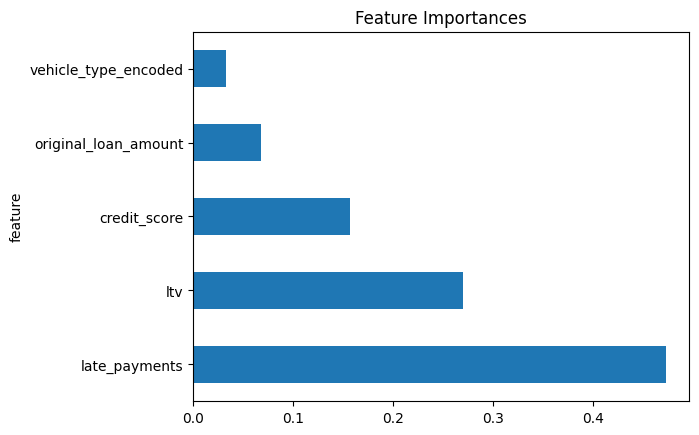

In [527]:
# Check what features you're actually using
print("Features:", X.columns.tolist())

# Look at the decision tree depth/complexity
print("Tree depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())

# Check feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance)
plt.figure(figsize=(15, 10))
feature_importance.plot(kind='barh', x='feature', y='importance', legend=False)
plt.title('Feature Importances')

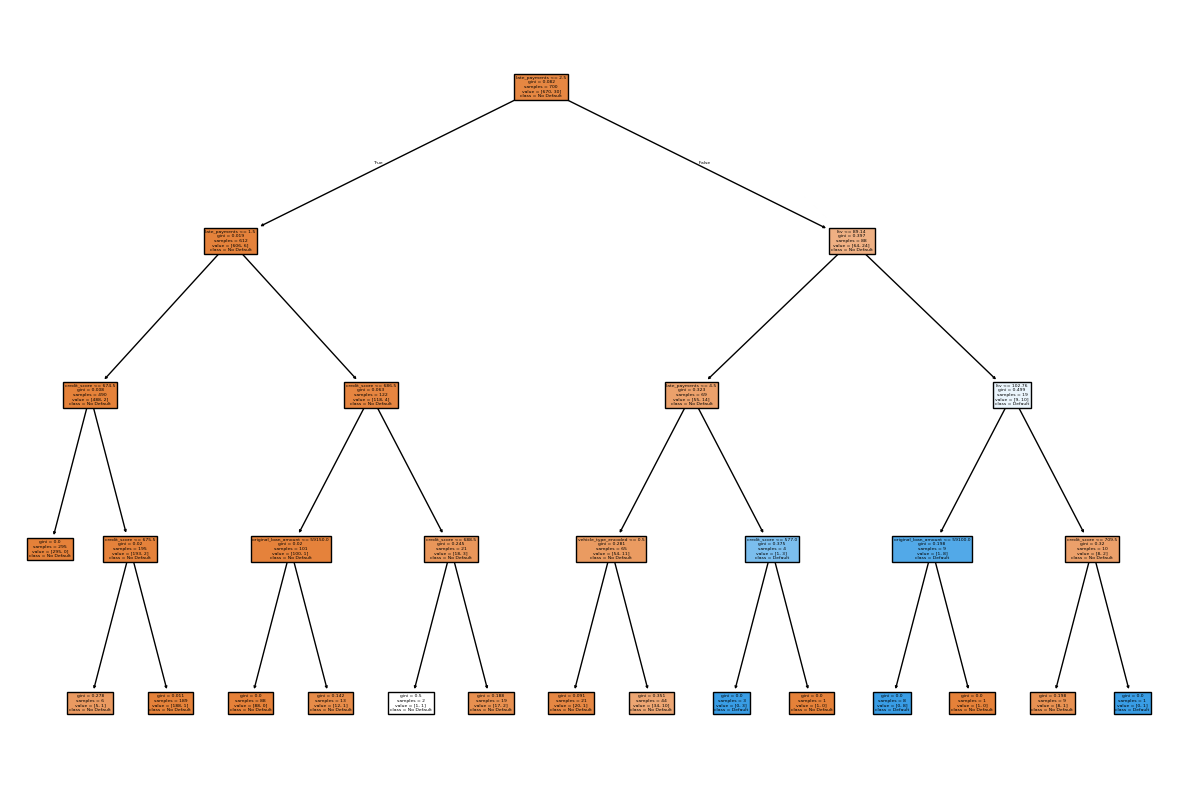

In [528]:
plt.figure(figsize=(15, 10))
plot_tree(clf, feature_names=X.columns, class_names=['No Default', 'Default'], filled=True)
plt.show()